# Visualización con Seaborn

Matplotlib ha demostrado ser una herramienta de visualización increíblemente útil y popular, 
pero incluso los usuarios entusiastas admitirán que a menudo deja mucho que desear. Hay varias quejas válidas sobre Matplotlib que a menudo surgen:

Antes de la versión 2.0, los valores predeterminados de Matplotlib no son exactamente las mejores opciones. 
Se basó en MATLAB alrededor de 1999, y esto a menudo se nota.

La API de Matplotlib es de nivel relativamente bajo. Es posible realizar una visualización estadística sofisticada, 
pero a menudo requiere mucho código repetitivo.
Matplotlib fue anterior a Pandas en más de una década y, por lo tanto, no está diseñado para su uso con Pandas DataFrames. 
Para visualizar datos de un Pandas DataFrame, debe extraer cada Serie y, a menudo, concatenarlas juntas en el formato correcto. 
Sería mejor tener una biblioteca de trazado que pueda usar inteligentemente las etiquetas de DataFrame en un trazado.

In [41]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd

In [42]:
# Create some data
rng = np.random.RandomState(0)
x = np.linspace(0, 10, 500)
y = np.cumsum(rng.randn(500, 6), 0)

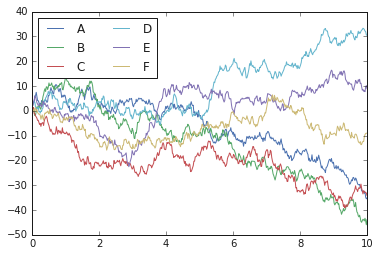

In [43]:
# Plot the data with Matplotlib defaults
plt.plot(x, y)
plt.legend('ABCDEF', ncol=2, loc='upper left');

Una respuesta a estos problemas es Seaborn. Seaborn proporciona una API sobre Matplotlib que ofrece opciones sensatas para el estilo de trazado y los valores predeterminados de color, define funciones simples de alto nivel para tipos de trazado estadísticos comunes, y se integra con la funcionalidad proporcionada por Pandas DataFrames.

In [44]:
import seaborn as sns
sns.set()

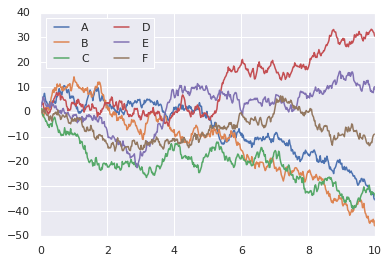

In [45]:
# same plotting code as above!
plt.plot(x, y)
plt.legend('ABCDEF', ncol=2, loc='upper left');

La idea principal de Seaborn es que proporciona comandos de alto nivel para crear una variedad de tipos de gráficos útiles para la exploración de datos estadísticos, e incluso algunos ajustes de modelos estadísticos.

Echemos un vistazo a algunos de los conjuntos de datos y tipos de gráficos disponibles en Seaborn. Tenga en cuenta que todo lo siguiente podría hacerse utilizando los comandos de Matplotlib sin procesar (esto es, de hecho, lo que hace Seaborn bajo el capó), pero la API de Seaborn es mucho más conveniente.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


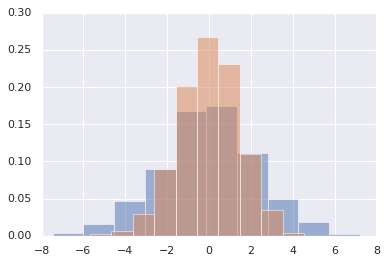

In [46]:
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])

for col in 'xy':
    plt.hist(data[col], normed=True, alpha=0.5)

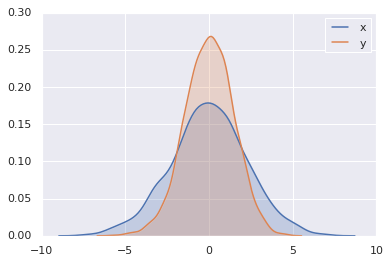

In [47]:
for col in 'xy':
    sns.kdeplot(data[col], shade=True)

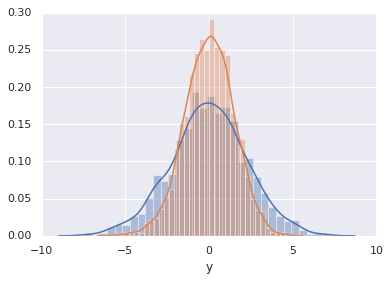

In [48]:
sns.distplot(data['x'])
sns.distplot(data['y']);

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


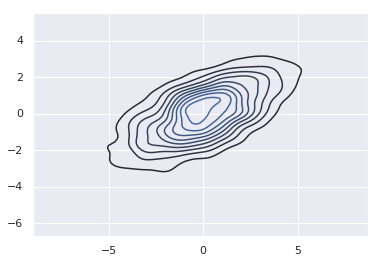

In [49]:
sns.kdeplot(data);

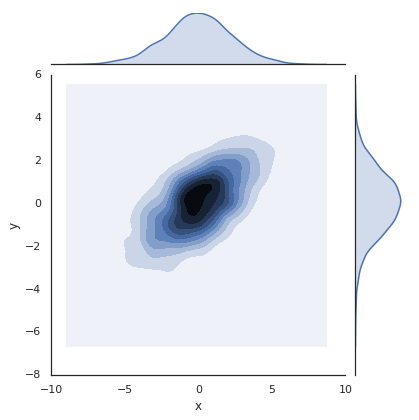

In [50]:
with sns.axes_style('white'):
    sns.jointplot("x", "y", data, kind='kde');

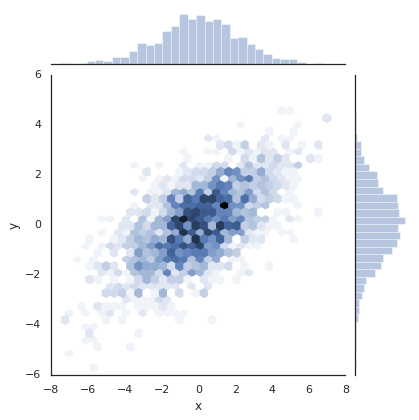

In [51]:
with sns.axes_style('white'):
    sns.jointplot("x", "y", data, kind='hex')

In [52]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


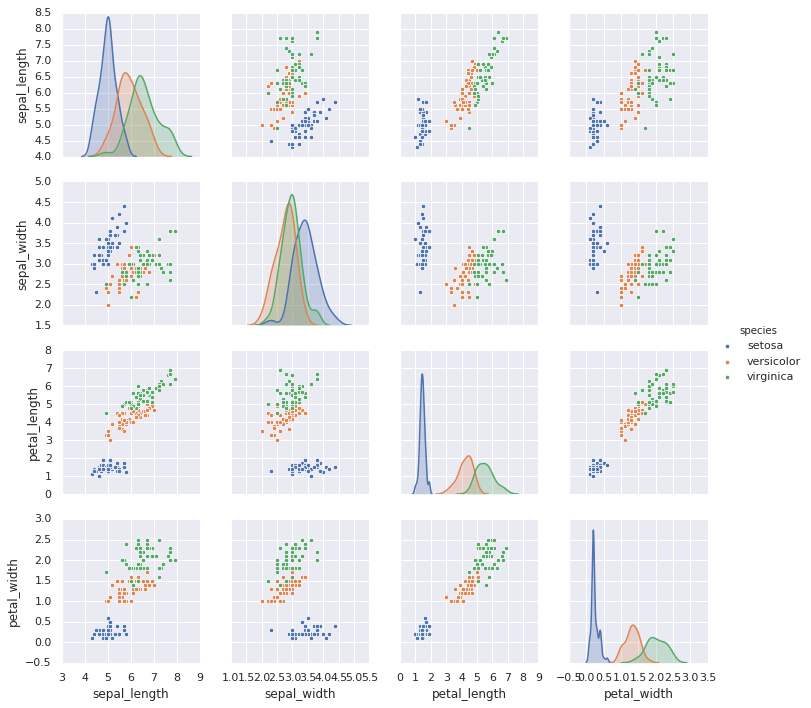

In [53]:
sns.pairplot(iris, hue='species', size=2.5);

# Histogramas

A veces, la mejor manera de ver los datos es a través de histogramas de subconjuntos. FacetGrid de Seaborn lo hace extremadamente simple. Echaremos un vistazo a algunos datos que muestran la cantidad que recibe el personal del restaurante en consejos basados en diversos datos del indicador:

In [54]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


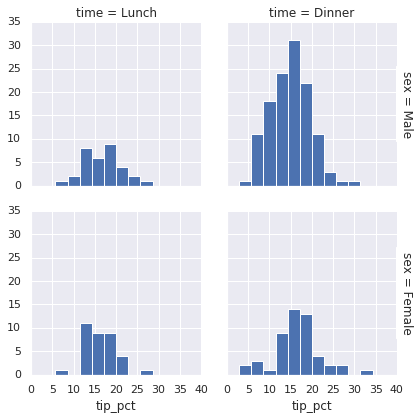

In [55]:
tips['tip_pct'] = 100 * tips['tip'] / tips['total_bill']

grid = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
grid.map(plt.hist, "tip_pct", bins=np.linspace(0, 40, 15));

# Gráficos de factores
Los gráficos de factores también pueden ser útiles para este tipo de visualización. Esto le permite ver la distribución de un parámetro dentro de los contenedores definidos por cualquier otro parámetro

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


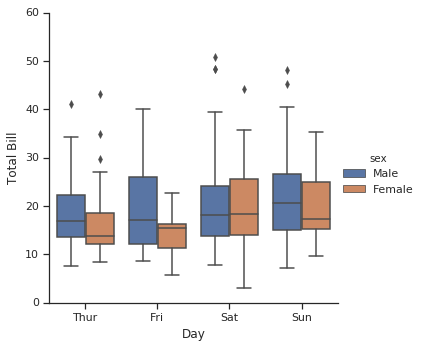

In [56]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("day", "total_bill", "sex", data=tips, kind="box")
    g.set_axis_labels("Day", "Total Bill");

# Distribuciones conjuntas
Similar al diagrama de pares que vimos anteriormente, podemos usar sns.jointplot para mostrar la distribución conjunta entre diferentes conjuntos de datos, junto con las distribuciones marginales asociadas:

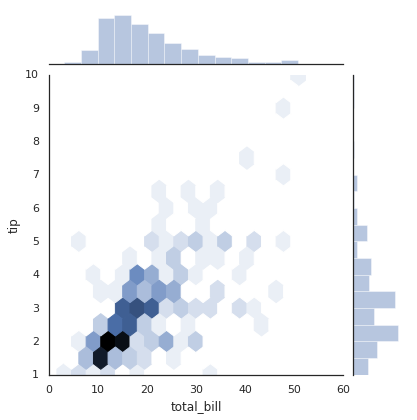

In [57]:
with sns.axes_style('white'):
    sns.jointplot("total_bill", "tip", data=tips, kind='hex')

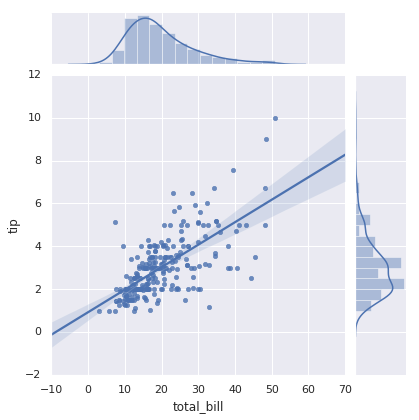

In [58]:
sns.jointplot("total_bill", "tip", data=tips, kind='reg');

In [59]:
planets = sns.load_dataset('planets')
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


# Gráficos de bar
Las series de tiempo se pueden trazar usando sns.factorplot. En el siguiente ejemplo, utilizaremos los datos de Planetas que vimos por primera vez en Agregación y agrupación:

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


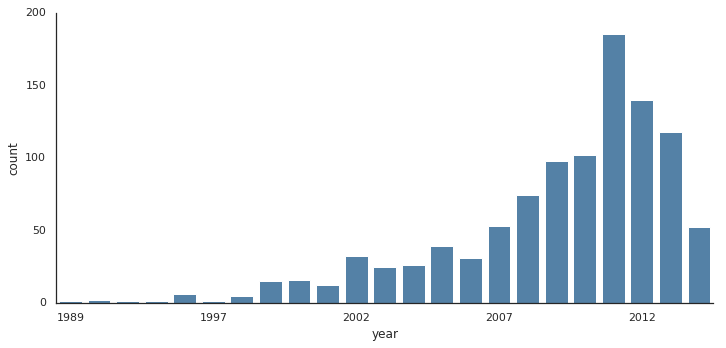

In [60]:
with sns.axes_style('white'):
    g = sns.factorplot("year", data=planets, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


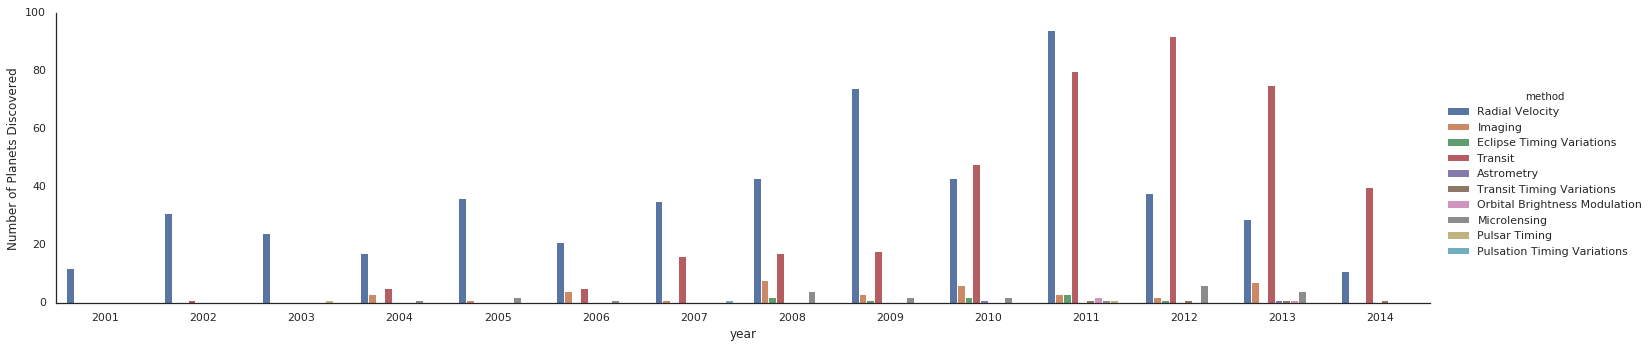

In [61]:
with sns.axes_style('white'):
    g = sns.factorplot("year", data=planets, aspect=4.0, kind='count',
                       hue='method', order=range(2001, 2015))
    g.set_ylabels('Number of Planets Discovered')

# Caso de uso

Explorando los tiempos de finalización del maratón
Aquí veremos cómo usar Seaborn para ayudar a visualizar y comprender los resultados finales de un maratón.

Comenzaremos descargando los datos de la Web y cargándolos en Pandas:

In [62]:
data = pd.read_csv('https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv')
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [63]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

In [64]:
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return pd.Timedelta(hours=h, minutes=m, seconds=s)

data = pd.read_csv('https://raw.githubusercontent.com/jakevdp/marathon-data/master/marathon-data.csv',
                   converters={'split':convert_time, 'final':convert_time})
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [65]:
data.dtypes

age                 int64
gender             object
split     timedelta64[ns]
final     timedelta64[ns]
dtype: object

In [66]:
data['split_sec'] = data['split'].astype(int) / 1E9
data['final_sec'] = data['final'].astype(int) / 1E9
data.head()

,age,gender,split,final,split_sec,final_sec
0,33,M,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,3992.0,8039.0


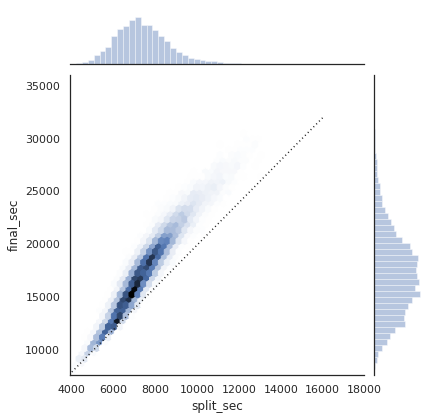

In [67]:
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000),
                    np.linspace(8000, 32000), ':k')

La línea punteada muestra dónde estaría el tiempo de alguien si corriera el maratón a un ritmo perfectamente estable. El hecho de que la distribución se encuentre por encima de esto indica (como es de esperar) que la mayoría de las personas disminuyen la velocidad durante el maratón. Si ha corrido de manera competitiva, sabrá que aquellos que hacen lo contrario, correr más rápido durante la segunda mitad de la carrera, se dice que han "dividido negativamente" la carrera.

Creemos otra columna en los datos, la fracción dividida, que mide el grado en que cada corredor divide positivamente la carrera:

In [68]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842


Cuando esta diferencia de división es menor que cero, la persona divide negativamente la raza por esa fracción. Hagamos un diagrama de distribución de esta fracción dividida:

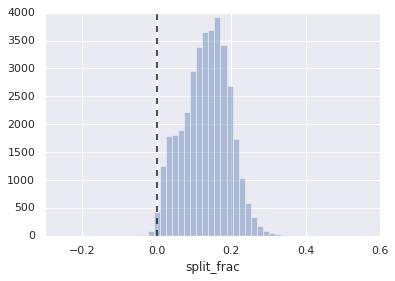

In [69]:
sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [79]:
sum(data.split_frac < 0)

251

De casi 40,000 participantes, solo había alrededor de 250 personas que dividieron negativamente su maratón.

Veamos si hay alguna correlación entre esta fracción dividida y otras variables. Haremos esto usando una cuadrícula de pares, que dibuja gráficos de todas estas correlaciones:

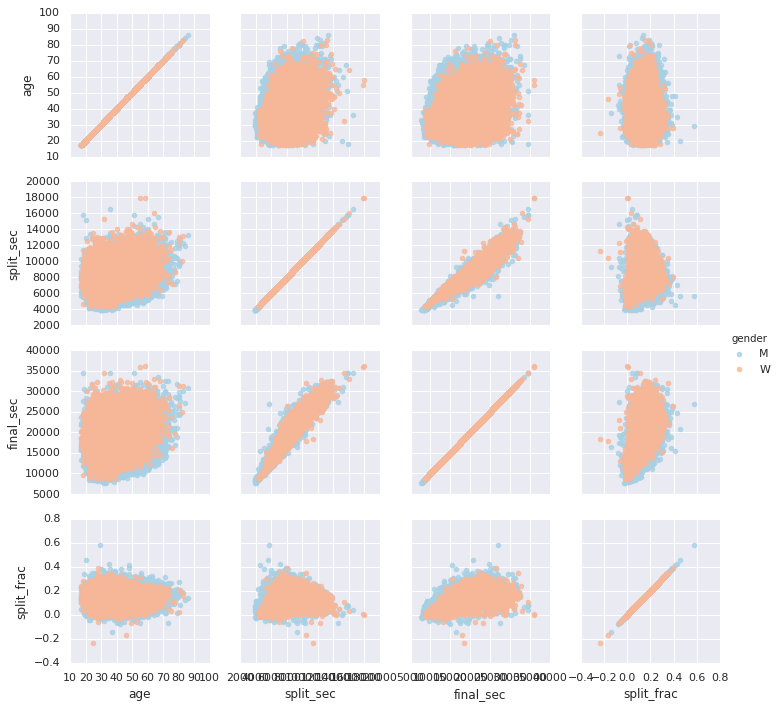

In [70]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

Parece que la fracción dividida no se correlaciona particularmente con la edad, pero se correlaciona con el tiempo final: los corredores más rápidos tienden a tener divisiones más cercanas incluso en su tiempo de maratón. (Vemos aquí que Seaborn no es la panacea para los males de Matplotlib cuando se trata de estilos de trazado: en particular, las etiquetas del eje x se superponen. Debido a que la salida es un trazado simple de Matplotlib, sin embargo, los métodos en Customizing Ticks pueden usarse para ajustar tales cosas si lo desea).

La diferencia entre hombres y mujeres aquí es interesante. Veamos el histograma de fracciones divididas para estos dos grupos:

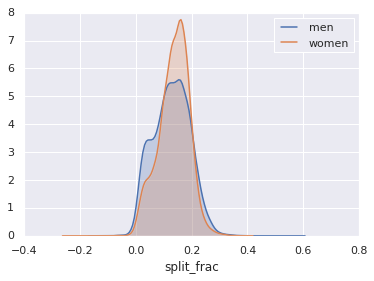

In [71]:
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

¡Lo interesante aquí es que hay muchos más hombres que mujeres que corren cerca de una división pareja! Esto casi parece una especie de distribución bimodal entre hombres y mujeres. Veamos si podemos descubrir lo que está sucediendo mirando las distribuciones en función de la edad.

Una buena manera de comparar distribuciones es usar una trama de violín

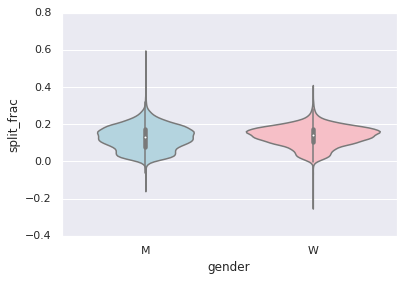

In [72]:
sns.violinplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"]);

Esta es otra forma de comparar las distribuciones entre hombres y mujeres.

Veamos un poco más profundo y comparemos estas parcelas de violín en función de la edad. Comenzaremos creando una nueva columna en la matriz que especifica la década de edad en que se encuentra cada persona:

In [73]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


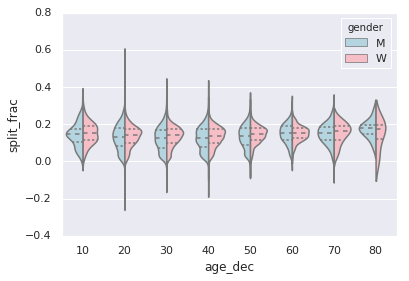

In [74]:
men = (data.gender == 'M')
women = (data.gender == 'W')

with sns.axes_style(style=None):
    sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);

Mirando esto, podemos ver en qué difieren las distribuciones de hombres y mujeres: las distribuciones divididas de hombres de 20 a 50 años muestran una pronunciada sobre-densidad hacia divisiones más bajas en comparación con mujeres de la misma edad (o de cualquier edad, por ejemplo). ese asunto).

También sorprendentemente, las mujeres de 80 años parecen superar a todos en términos de su tiempo parcial. Esto probablemente se deba al hecho de que estamos estimando la distribución a partir de números pequeños, ya que solo hay un puñado de corredores en ese rango:

In [75]:
(data.age > 80).sum()

7

Volviendo a los hombres con divisiones negativas: ¿quiénes son estos corredores? ¿Esta fracción dividida se correlaciona con terminar rápidamente? Podemos trazar esto muy fácilmente. Usaremos regplot, que ajustará automáticamente una regresión lineal a los datos:

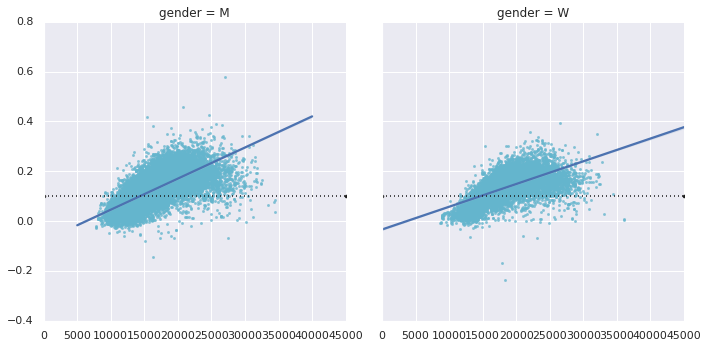

In [76]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Aparentemente, las personas con divisiones rápidas son los corredores de élite que están terminando en ~ 15,000 segundos, o alrededor de 4 horas. Las personas más lentas que eso tienen muchas menos probabilidades de tener una segunda división rápida.